In [1]:
# Import libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr, iqr
from datetime import datetime
from statsmodels.robust.scale import mad as mad_c
import copy

from sklearn.linear_model import LinearRegression, HuberRegressor


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


# Set path for generated figures
fig_path = './figures_4.4/'

# set the scaling factor to 1
def mad(a):
    return mad_c(a, c=1)

In [2]:
# Read data
mydateparser = lambda x: datetime.strptime(x, "%Y-%m-%d")

AAPL = pd.read_csv("AAPL.csv", index_col=0, parse_dates=True, date_parser=mydateparser)
IBM = pd.read_csv("IBM.csv", index_col=0, parse_dates=True, date_parser=mydateparser)
JPM = pd.read_csv("JPM.csv", index_col=0, parse_dates=True, date_parser=mydateparser)
DJI = pd.read_csv("DJI.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

stocks_data = {'APPL': AAPL, 'IBM': IBM, 'JPM': JPM, 'DJI': DJI}

## 4.4 Robust Trading Strategies

The *Moving Average Crossover* is a simple trading strategy based on the following rules:

- Buy $X$ shares of a stock when its 20-day MA $>$ 50-day MA
- Sell X shares of the stock when its 20-day MA $<$ 50-day MA

In this section, we will implement the simple and a robust variation of the Moving Average Crossover strategy.

In [3]:
# adjusted closes
adj_closes = pd.DataFrame(columns = stocks_data.keys())
for stock in adj_closes.columns:
    adj_closes[stock] = stocks_data[stock]['Adj Close']
    
# corrupted adjusted closes
corrupted_adj_closes = copy.deepcopy(adj_closes)
for stock in corrupted_adj_closes.columns:
    adj_close = corrupted_adj_closes[stock]
    max_val = adj_close.max()
    min_val = adj_close.min()
    for i in range(0,250, 25):
        adj_close.iloc[i] = max_val * 1.2
    for i in range(15,250, 25):
        adj_close.iloc[i] = min_val * 0.8

In [4]:
def get_decisions(signs):
    decision = {'start': signs.index[0], 'end': None, 'val': signs[0]}
    decisions = [decision]
    for t in signs.index:
        if decisions[-1]['end'] != None:
            decision = {'start': next_start, 'end': None, 'val': signs[t]}
            decisions.append(decision)

        val = signs[t]
        if decisions[-1]['val'] == val:
            continue
        else:
            decisions[-1]['end'] = t
            next_start = t

    decisions[-1]['end'] = signs.index[-1]

    return decisions

<a id='4.4.1'></a>
### 4.4.1 Simple Moving Average Crossover

For each stock, the adjacency close and its 20 and 50-day **rolling mean** moving averages are plotted on the left in the figures below, and the buy (blue) and sell (red) regions are highlighted according to the crossover strategy. The performance of this strategy in terms of cumulative returns is also provided for each stock. Then, the same steps are repeated for corrupted adjacency close prices, and the corresponding plots are given on the right in the same figure. 

The buy and sell region overlaps are given in the table below to illustrate the robustness of this strategy in the presence of outliers.

Region overlap APPL:	89.6%
Region overlap IBM:	86.1%
Region overlap JPM:	84.2%
Region overlap DJI:	85.1%


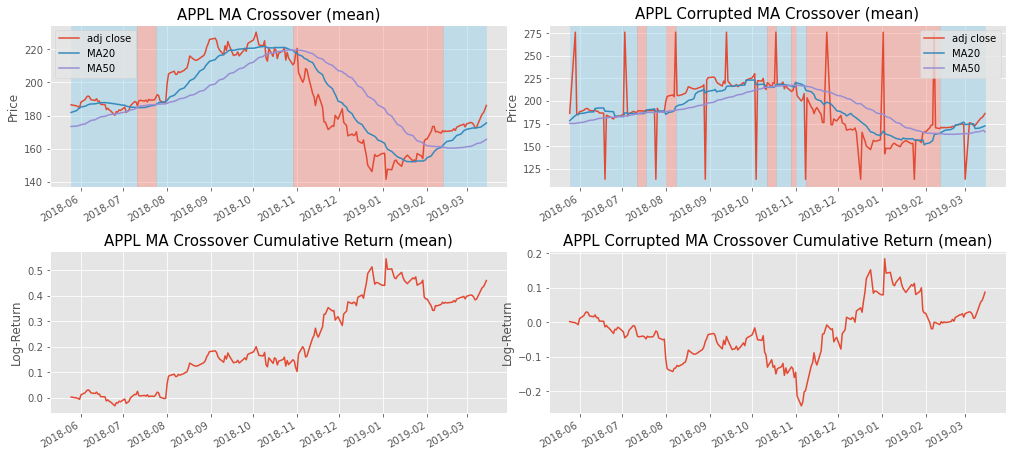

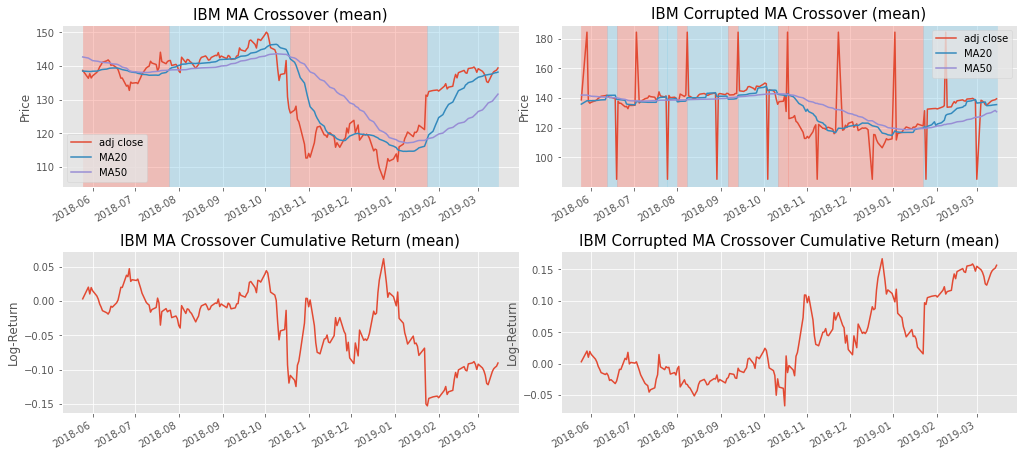

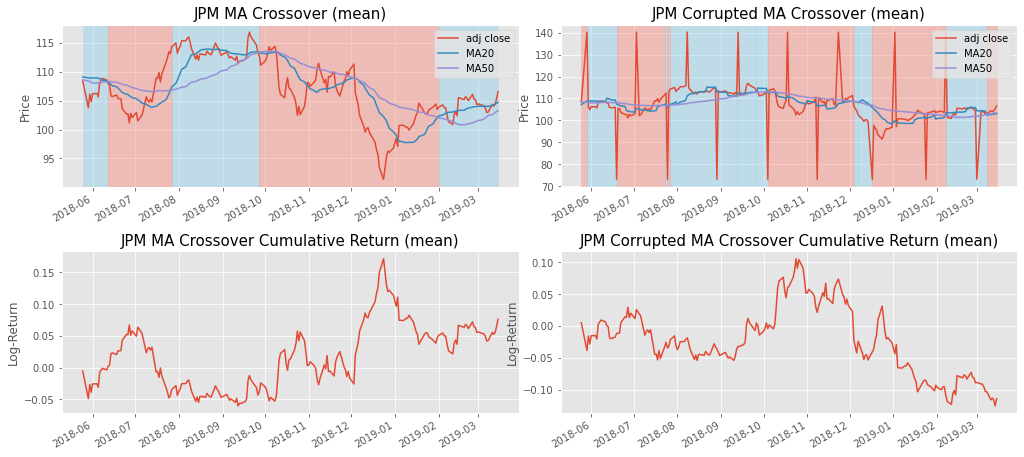

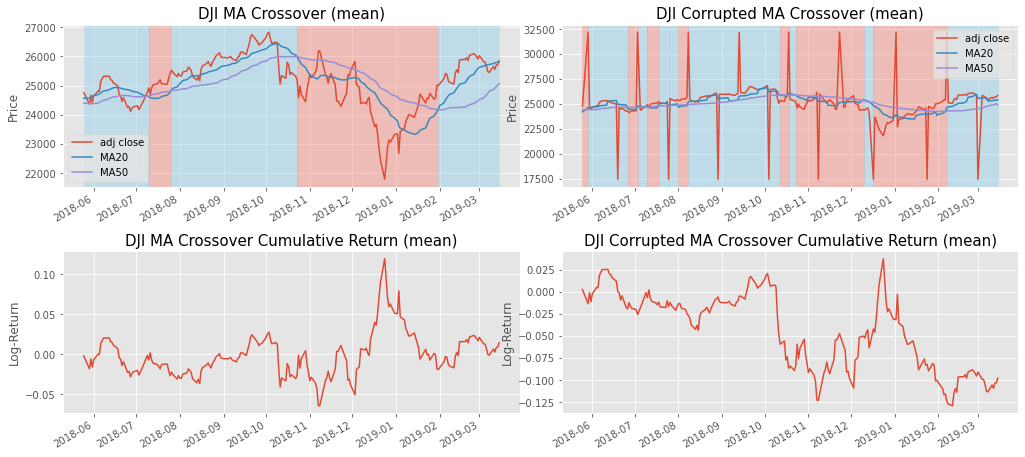

In [5]:
for stock in adj_closes.columns:
    fig, axes = plt.subplots(2,2, figsize=(14,7))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4)
    
    # Moving Average Crossover ---------------------------------------------------------------------------
    adj_close = adj_closes[stock]

    ma20 = adj_close.rolling(20).mean().dropna()
    ma50 = adj_close.rolling(50).mean().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,0]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')

    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')

    ax.legend()
    ax.set_title(stock+" MA Crossover (mean)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')

    # cumulative returns
    returns = np.log(adj_close).diff()[idx:]
    returns = returns * ma_signs

    ax = axes[1,0]
    returns.cumsum().plot(ax=ax)

    ax.set_title(stock+" MA Crossover Cumulative Return (mean)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')


    

    # Moving Average Crossover with outliers -------------------------------------------------------------
    adj_close = corrupted_adj_closes[stock]

    ma20 = adj_close.rolling(20).mean().dropna()
    ma50 = adj_close.rolling(50).mean().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs_corrupted = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,1]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')

    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')

    ax.legend()
    ax.set_title(stock+" Corrupted MA Crossover (mean)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')


    # cumulative returns
    returns = np.log(adj_closes[stock]).diff()[idx:]
    returns = returns * ma_signs

    ax = axes[1,1]
    returns.cumsum().plot(ax=ax)

    ax.set_title(stock+" Corrupted MA Crossover Cumulative Return (mean)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')

    # ----------------------------------------------------------------------------------------------------
    print('Region overlap {}:\t{:.1%}'.format(stock, (signs == signs_corrupted).sum()/len(signs)))
    fig.savefig(fig_path+'Rolling_Mean_Moving_Average_Crossover_Strategy_'+stock+'.png', dpi=200, bbox_inches='tight')    

We observe that the cross-over regions, and as a result buy and sell decisions, are largely affected by the presence of outliers, leading to significant differences in performances. This suggests the susceptibility of rolling means to outliers. 

<a id='4.4.2'></a>
### 4.4.2 Robust Moving Average Crossover

We repeat the analysis in [4.4.1](#4.4.1) using the **rolling median** instead of the rolling mean and obtain the following plots.

Region overlap APPL:	98.5%
Region overlap IBM:	98.0%
Region overlap JPM:	97.0%
Region overlap DJI:	98.5%


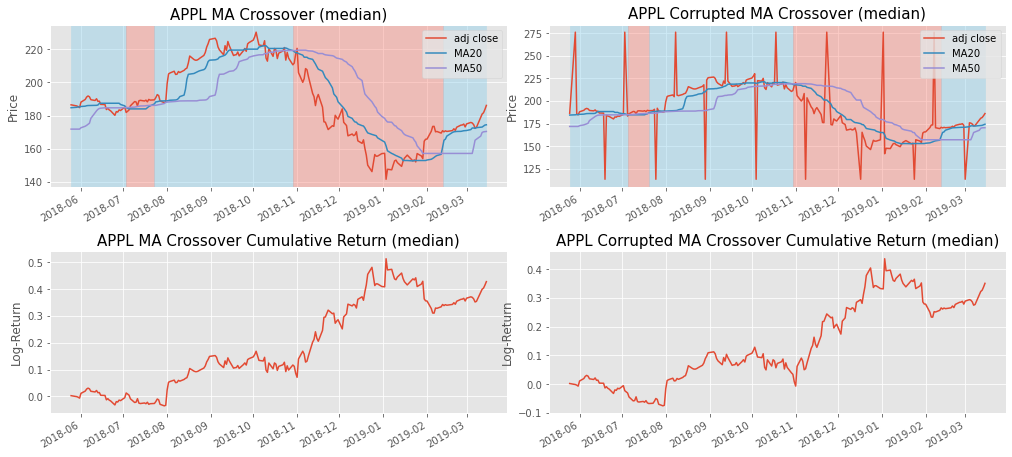

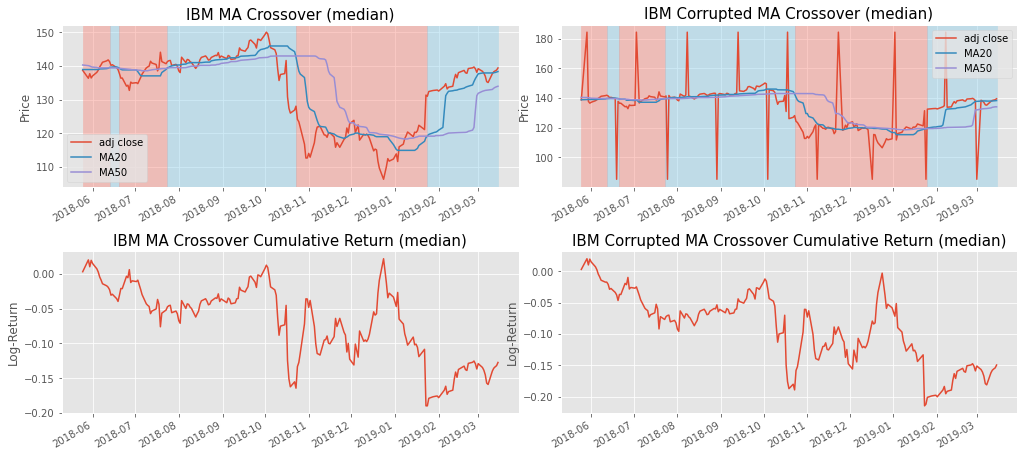

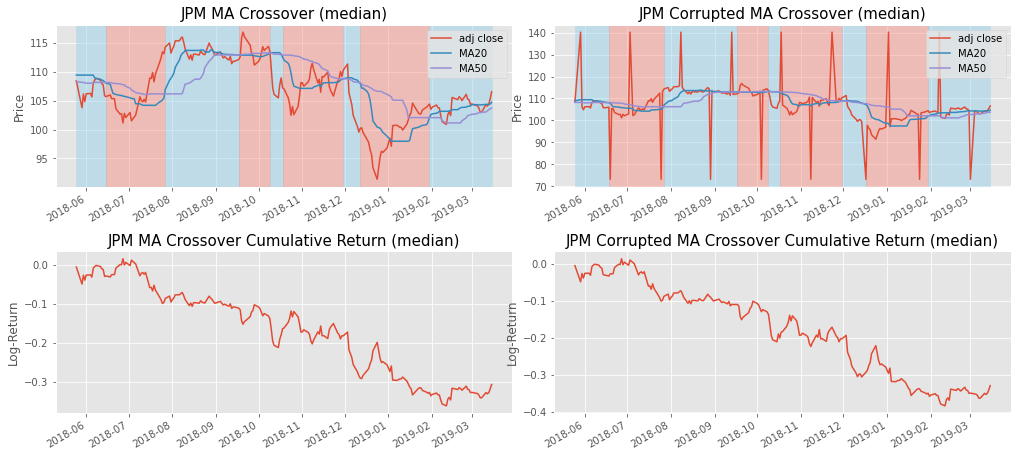

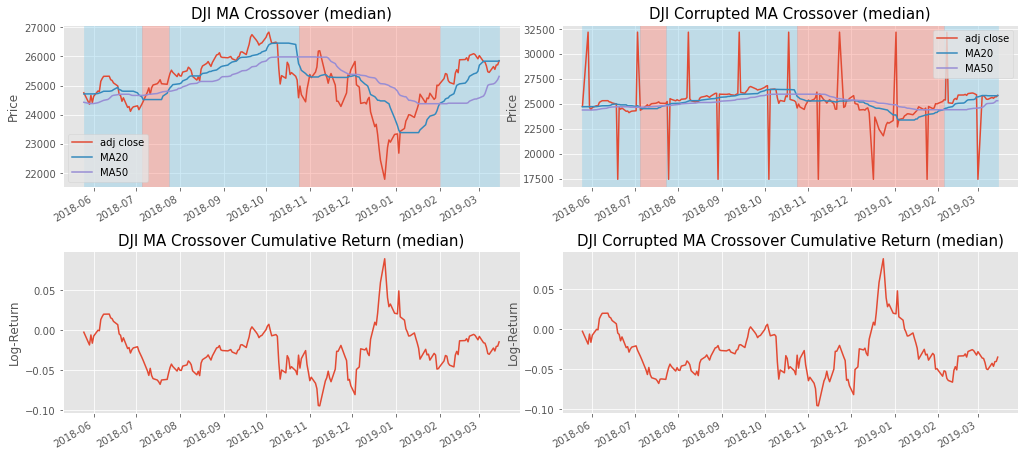

In [6]:
for stock in adj_closes.columns:
    fig, axes = plt.subplots(2,2, figsize=(14,7))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4)
    
    # Moving Average Crossover (median) ---------------------------------------------------------------------------
    adj_close = adj_closes[stock]

    ma20 = adj_close.rolling(20).median().dropna()
    ma50 = adj_close.rolling(50).median().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,0]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')

    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')

    ax.legend()
    ax.set_title(stock+" MA Crossover (median)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')

    # cumulative returns
    returns = np.log(adj_close).diff()[idx:]
    returns = returns * ma_signs

    ax = axes[1,0]
    returns.cumsum().plot(ax=ax)

    ax.set_title(stock+" MA Crossover Cumulative Return (median)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')



    
    # Moving Average Crossover with outliers (median) -------------------------------------------------------------
    adj_close = corrupted_adj_closes[stock]

    ma20 = adj_close.rolling(20).median().dropna()
    ma50 = adj_close.rolling(50).median().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs_corrupted = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,1]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')

    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')

    ax.legend()
    ax.set_title(stock+" Corrupted MA Crossover (median)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')


    # cumulative returns
    returns = np.log(adj_closes[stock]).diff()[idx:]
    returns = returns * ma_signs

    ax = axes[1,1]
    returns.cumsum().plot(ax=ax)

    ax.set_title(stock+" Corrupted MA Crossover Cumulative Return (median)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')

    # ----------------------------------------------------------------------------------------------------
    print('Region overlap {}:\t{:.1%}'.format(stock, (signs == signs_corrupted).sum()/len(signs)))
    fig.savefig(fig_path+'Rolling_Median_Moving_Average_Crossover_Strategy_'+stock+'.png', dpi=200, bbox_inches='tight')    

It is clear from the highlighting of the plots and the region overlaps given in the table above that the rolling median is much more robust to outliers than is the rolling mean. The buy and sell decisions generated using the rolling median are almost identical in the non-corrupted and corrupted cases, and as a result, so are the cumulative return signals.

Therefore, similar to the analysis in the previous sections, we conclude that it may not be appropriate to use the mean to estimate the average of a signal in the presence of outliers. The robustness of the median against outliers, makes the median a better choice in defining corrupted signals.